In [1]:
import pandas as pd

## Load and clean dataset

Loading multiple CSV files and combining them into a single dataset, then cleaning it by removing rows with missing values.

In [28]:
BASE_DIR = './testing_dataset_article_category/'

# Load dataset
injuries_df = pd.read_csv(BASE_DIR + 'injuries.csv')
interview_df = pd.read_csv(BASE_DIR + 'interview.csv')
prematch_df = pd.read_csv(BASE_DIR + 'prematch.csv')
reaction_df = pd.read_csv(BASE_DIR + 'reaction.csv')
report_df = pd.read_csv(BASE_DIR + 'report.csv')
transfers_df = pd.read_csv(BASE_DIR + 'transfers.csv')

In [29]:
dataset = pd.concat([
    injuries_df,
    interview_df,
    prematch_df,
    reaction_df,
    report_df,
    transfers_df
], ignore_index=True)

display(dataset.head())
display(dataset.tail())

,title,perex,label
0,Realu se vážně zranil Asensio. Ceballos by měl...,Real Madrid potenciálně na celý ročník 2019/20...,Injuries
1,Problémy s koleny dohnaly Richardse k brzkému ...,Už ve 31 letech dohnaly neustálé problémy s ko...,Injuries
2,Verletzungspech bei Real - Kreuzband-Schock fü...,Schock bei Real Madrid! Marco Asensio erlitt i...,Injuries
3,Man Utd star Eric Bailly to miss ‘at least six...,MANCHESTER UNITED star Eric Bailly is set to m...,Injuries
4,Вутов под въпрос за мача с Левски,Един от основните футболисти на Ботев (Пловдив...,Injuries


,title,perex,label
1495,Zinedine Zidane hints Dani Ceballos’ long-term...,Disappointing?,Transfers
1496,Arsenal new signing Dani Ceballos reveals how ...,Arsenal new boy Dani Ceballos has revealed tha...,Transfers
1497,&#039;Arsenal bereidt bod van 40 miljoen voor ...,Arsenal bereidt momenteel een miljoenenbod voo...,Transfers
1498,Simons není sám. Barceloně uteklo poslední dob...,V tomto týdnu rozvířilo vody barcelonského klu...,Transfers
1499,La Stampa: Spurs brengt openingsbod van 50 mil...,De interesse van Tottenham Hotspur in Paulo Dy...,Transfers


In [30]:
dataset.columns

Index(['title', 'perex', 'label'], dtype='object')

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1500 non-null   object
 1   perex   1499 non-null   object
 2   label   1500 non-null   object
dtypes: object(3)
memory usage: 35.3+ KB


Let's just drop a row with missing values for simplicity.

In [19]:
nan_rows = dataset[dataset.isna().any(axis=1)]
display(nan_rows)

,title,perex,label
201,Slavia i Sparta chtějí v pohárovém derby odčin...,NaN,Pre-Match


In [32]:
dataset.dropna(inplace=True)

In [33]:
dataset

,title,perex,label
0,Realu se vážně zranil Asensio. Ceballos by měl...,Real Madrid potenciálně na celý ročník 2019/20...,Injuries
1,Problémy s koleny dohnaly Richardse k brzkému ...,Už ve 31 letech dohnaly neustálé problémy s ko...,Injuries
2,Verletzungspech bei Real - Kreuzband-Schock fü...,Schock bei Real Madrid! Marco Asensio erlitt i...,Injuries
3,Man Utd star Eric Bailly to miss ‘at least six...,MANCHESTER UNITED star Eric Bailly is set to m...,Injuries
4,Вутов под въпрос за мача с Левски,Един от основните футболисти на Ботев (Пловдив...,Injuries
...,...,...,...
1495,Zinedine Zidane hints Dani Ceballos’ long-term...,Disappointing?,Transfers
1496,Arsenal new signing Dani Ceballos reveals how ...,Arsenal new boy Dani Ceballos has revealed tha...,Transfers
1497,&#039;Arsenal bereidt bod van 40 miljoen voor ...,Arsenal bereidt momenteel een miljoenenbod voo...,Transfers
1498,Simons není sám. Barceloně uteklo poslední dob...,V tomto týdnu rozvířilo vody barcelonského klu...,Transfers


In [34]:
dataset['label'].unique()

array(['Injuries', 'Interview', 'Pre-Match', 'Reaction', 'Report',
       'Transfers'], dtype=object)

Then we save the cleaned dataset to a new CSV file to be used later in the training and evaluation process of Transformers models.

In [23]:
dataset.to_csv('dataset_cleaned.csv', index=False)

### Analyze results from a trained Transformers model

The following code analyzes the results of a trained Transformers text classification model. It reads various output files generated during model evaluation, such as classification reports, confusion matrices, and prediction probabilities. The code visualizes the confusion matrix, identifies common misclassifications, and examines the relationship between prediction confidence and accuracy.

The whole preprocessing and training pipeline can be found in the `topic_classifier_pipeline.py` file.

In [35]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LABELS = ["Injuries", "Interview", "Pre-Match", "Reaction", "Report", "Transfers"]

# Change if needed:
RUN_DIR = Path("runs_FINAL_concat_split42_seed101") / "baseline" / "single_run"
OUT_DIR = RUN_DIR

# Helper
def read_json(p: Path):
    if not p.exists():
        return None
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=axis, keepdims=True)

JSON summary of the results.

In [37]:
compare = read_json(RUN_DIR.parent.parent / "compare_summary.json")  # runs_FINAL.../compare_summary.json
print(json.dumps(compare, indent=2)[:3000])

{
  "baseline": {
    "val": {
      "eval_loss": 0.4191313683986664,
      "eval_accuracy": 0.7822222222222223,
      "eval_f1_macro": 0.6482354602414419,
      "eval_f1_weighted": 0.7758504754873052,
      "eval_runtime": 6.2388,
      "eval_samples_per_second": 36.065,
      "eval_steps_per_second": 0.641,
      "epoch": 3.0
    },
    "test": {
      "accuracy": 0.7866666666666666,
      "f1_macro": 0.6441437221679157,
      "f1_weighted": 0.7758393070489846
    }
  }
}


As the original dataset is imbalanced, we can check the class weights used during training. These weights help the model pay more attention to underrepresented classes.

In [4]:
cw = read_json(RUN_DIR / "class_weights.json")
cw

{'mode': 'sqrt_inv',
 'effective_beta': 0.99,
 'label_smoothing': 0.0,
 'focal_gamma': 1.0,
 'weights': {'Injuries': 1.1270890433990295,
  'Interview': 1.1270890433990295,
  'Pre-Match': 1.1352269761077518,
  'Reaction': 0.35641685029613,
  'Report': 1.1270890433990295,
  'Transfers': 1.1270890433990295}}

Save the report as a tidy dataframe for easier analysis. The report includes precision, recall, F1-score, and support for each class. macro and weighted averages are also included.

**Macro average**

	•	Compute the metric separately for each class, then take the simple mean across classes.
	•	Every class gets equal weight, even if one class is rare.

So macro-F1 answers: “How well do I do on an average class?”
It’s the go-to when you care about minority classes and your dataset is imbalanced.

**Weighted average**

	•	Compute the metric per class, then take an average weighted by each class’s support (how many true examples of that class).
	•	Big classes influence the result much more than small ones.

So weighted-F1 answers: “How well do I do on the average example?”
In an imbalanced dataset, it can look good even if the model is weak on rare classes.

## Precision
**Of everything the model predicted as class X, how many were actually class X?**
High precision ⇒ few *false positives*.

**Formula:** precision = TP / (TP + FP)

## Recall
**Of everything that truly is class X, how many did the model find?**
High recall ⇒ few *false negatives*.

**Formula:** recall = TP / (TP + FN)

## F1-score
**Single number that balances precision and recall** (their harmonic mean).
High F1 typically requires both precision and recall to be reasonably high.

**Formula:** F1 = 2 · (precision · recall) / (precision + recall)

## Support
**How many true examples of the class exist in the evaluated set.**
Support is *not* a performance metric; it tells you how much data that class has.

**Example:** support=15 means there were 15 ground-truth items of that class.


In [13]:
rep = read_json(RUN_DIR / "test_classification_report.json")

# Convert to a tidy dataframe (per-class + averages)
rows = []
for k, v in rep.items():
    if isinstance(v, dict) and all(m in v for m in ["precision", "recall", "f1-score", "support"]):
        rows.append({
            "label": k,
            "precision": v["precision"],
            "recall": v["recall"],
            "f1": v["f1-score"],
            "support": v["support"],
        })
rep_df = pd.DataFrame(rows).sort_values(["label"]).reset_index(drop=True)
rep_df

,label,precision,recall,f1,support
0,Injuries,0.800000,0.800000,0.800000,15.0
1,Interview,0.571429,0.266667,0.363636,15.0
2,Pre-Match,0.500000,0.400000,0.444444,15.0
3,Reaction,0.841772,0.886667,0.863636,150.0
4,Report,0.562500,0.600000,0.580645,15.0
5,Transfers,0.764706,0.866667,0.812500,15.0
6,macro avg,0.673401,0.636667,0.644144,225.0
7,weighted avg,0.774424,0.786667,0.775839,225.0


### Confusion matrix visualization on test set. Raw counts and row-normalized.

In [14]:
cm_path = RUN_DIR / "test_confusion_matrix.csv"

cm_df = pd.read_csv(cm_path, index_col=0)
cm = cm_df.values.astype(int)

cm_df

,pred:Injuries,pred:Interview,pred:Pre-Match,pred:Reaction,pred:Report,pred:Transfers
true:Injuries,12,0,0,3,0,0
true:Interview,1,4,0,9,0,1
true:Pre-Match,0,0,6,7,0,2
true:Reaction,2,2,5,133,7,1
true:Report,0,0,1,5,9,0
true:Transfers,0,1,0,1,0,13


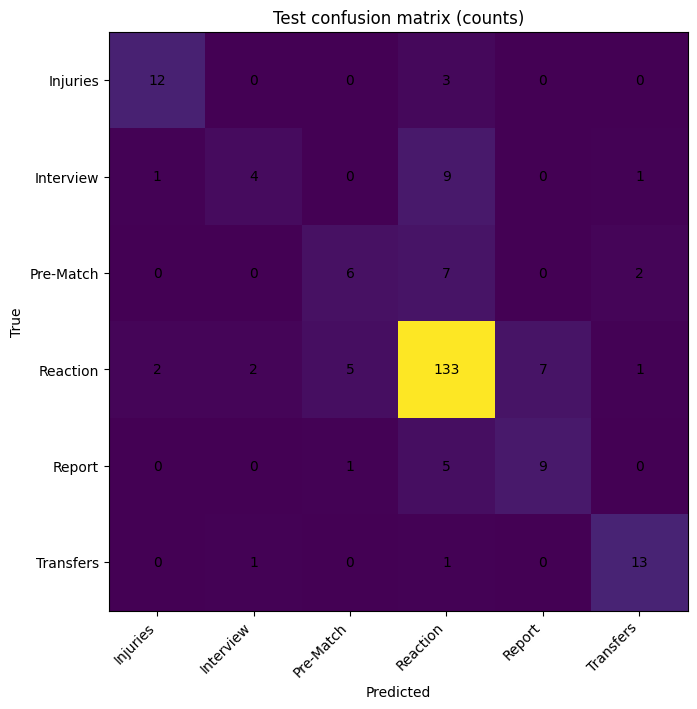

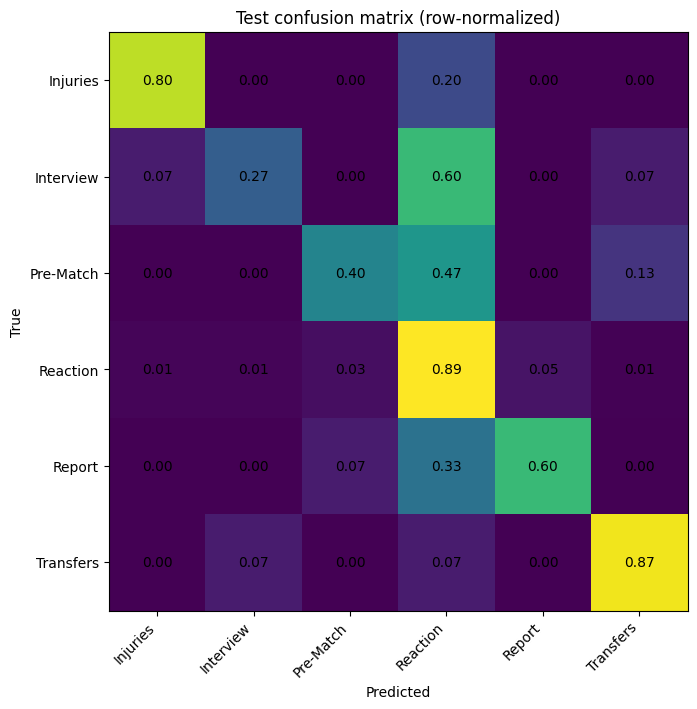

In [15]:
def plot_cm(cm, labels, normalize=False, title="Confusion matrix"):
    mat = cm.astype(float)
    if normalize:
        row_sums = mat.sum(axis=1, keepdims=True) + 1e-12
        mat = mat / row_sums

    plt.figure(figsize=(9, 7))
    plt.imshow(mat, interpolation="nearest")
    plt.title(title)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)

    # annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            txt = f"{val:.2f}" if normalize else f"{int(val)}"
            plt.text(j, i, txt, ha="center", va="center")

    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(cm, LABELS, normalize=False, title="Test confusion matrix (counts)")
plot_cm(cm, LABELS, normalize=True, title="Test confusion matrix (row-normalized)")

### Load predictions + logits, build an analysis table

- test_true.npy / test_pred.npy tell you what was right/wrong, but not how confident the model was.
- test_logits.npy → softmax gives you probabilities, so you can measure confidence, find overconfident mistakes, and decide on things like rejecting low-confidence predictions or thresholding.
- Building df_pred puts everything into one row-per-example table, so you can easily:

    filter correct == False to see errors,

    sort by conf to find high-confidence failures (label noise / systematic confusion),

    group by true_label/pred_label to find dominant confusions,

    analyze performance by text length, language, source, etc. (if you merge metadata from test_predictions.csv).

In [43]:
pred_csv_p = RUN_DIR / "test_predictions.csv"

df_pred = pd.read_csv(pred_csv_p)

# Standardize a few convenience columns (works even if some are missing)
df_pred["true_label"] = df_pred["label"]

df_pred["correct"] = (df_pred["pred_label"] == df_pred["true_label"])

df_pred = df_pred.rename(columns={"pred_conf": "conf"})

df_pred.head()

,title,perex,label,lang,labels,text,pred_label,conf,true_label,correct
0,Lieberknecht kämpferisch: &quot;Ich freue mich...,Der MSV Duisburg hat die Abstiegssaison mit ei...,Reaction,unk,3,Lieberknecht kämpferisch: &quot;Ich freue mich...,Reaction,0.415572,Reaction,True
1,Vincent Kompany verkündet Abschied von Manches...,Manchester Citys Kapitän Vincent Kompany hat n...,Reaction,unk,3,Vincent Kompany verkündet Abschied von Manches...,Interview,0.266956,Reaction,False
2,"Expert Duda po Švédech: Hokej, jaký chci vidět...","Běhal mu mráz po zádech i na Mallorce, odkud s...",Reaction,unk,3,"Expert Duda po Švédech: Hokej, jaký chci vidět...",Reaction,0.518474,Reaction,True
3,Sport24.co.za | Eriksen admits Spurs flopped i...,Christian Eriksen admitted Tottenham were well...,Reaction,unk,3,Sport24.co.za | Eriksen admits Spurs flopped i...,Reaction,0.434949,Reaction,True
4,Tennis - Roland-Garros - Herbert : «Il y a deu...,Pierre-Hugues Herbert (FRA/éliminé au 2e tour ...,Reaction,unk,3,Tennis - Roland-Garros - Herbert : «Il y a deu...,Reaction,0.337675,Reaction,True


In [44]:
err = df_pred[~df_pred["correct"]].copy()
confusions = (
    err.groupby(["true_label", "pred_label"])
       .size()
       .reset_index(name="count")
       .sort_values("count", ascending=False)
       .reset_index(drop=True)
)
confusions.head(20)

,true_label,pred_label,count
0,Interview,Reaction,9
1,Pre-Match,Reaction,7
2,Reaction,Report,7
3,Reaction,Pre-Match,5
4,Report,Reaction,5
5,Injuries,Reaction,3
6,Pre-Match,Transfers,2
7,Reaction,Injuries,2
8,Reaction,Interview,2
9,Interview,Injuries,1


In [45]:
 # For each true class: top wrong prediction
top_wrong_by_true = (
    confusions.groupby("true_label")
              .head(1)
              .sort_values("count", ascending=False)
)
top_wrong_by_true

,true_label,pred_label,count
0,Interview,Reaction,9
1,Pre-Match,Reaction,7
2,Reaction,Report,7
4,Report,Reaction,5
5,Injuries,Reaction,3
13,Transfers,Interview,1


In [46]:
cols = ["true_label", "pred_label", "conf"]
if "title" in df_pred.columns: cols += ["title"]
if "perex" in df_pred.columns: cols += ["perex"]
if "text" in df_pred.columns: cols += ["text"]

high_conf_wrong = (
    df_pred[~df_pred["correct"]]
    .sort_values("conf", ascending=False)
    .head(25)[cols]
)
high_conf_wrong

,true_label,pred_label,conf,title,perex,text
137,Reaction,Injuries,0.594760,Morris rues more Sharks NRL injuries,Cronulla coach John Morris cannot believe his ...,Morris rues more Sharks NRL injuries [SEP] Cro...
35,Pre-Match,Transfers,0.533447,Hevder Real Madrid vil kapre stjerneskuddet Sa...,Vil gi Manchester United og andre storklubber ...,Hevder Real Madrid vil kapre stjerneskuddet Sa...
104,Transfers,Interview,0.532154,Van Luik naar Amsterdam: &quot;Ik ben blij dat...,Razvan Marin verruilde Standard Luik deze zome...,Van Luik naar Amsterdam: &quot;Ik ben blij dat...
143,Reaction,Injuries,0.519774,Boleslav reaguje na zranění Růžičky: z Finska ...,Po dvou letech ve Finsku se do Mladé Boleslavi...,Boleslav reaguje na zranění Růžičky: z Finska ...
219,Reaction,Report,0.512760,Valusa kaotuse saanud Anett Kontaveit: tundsin...,Eesti esireket Anett Kontaveit (WTA 17.) lange...,Valusa kaotuse saanud Anett Kontaveit: tundsin...
66,Reaction,Report,0.508575,"Tennis - Roland-Garros - Timea Bacsinszky, le ...","A 29 ans, Timea Bacsinszky, double demi-finali...","Tennis - Roland-Garros - Timea Bacsinszky, le ..."
58,Reaction,Report,0.505127,"Roland Garros: Naomi Osaka, Dominic Thiem Batt...",Naomi Osaka came back from a set down to beat ...,"Roland Garros: Naomi Osaka, Dominic Thiem Batt..."
94,Interview,Reaction,0.502219,Kovařík po výbuchu: Na standardky jsme se chys...,Trenér Pavel Vrba ho poslal v druhém poločase ...,Kovařík po výbuchu: Na standardky jsme se chys...
195,Reaction,Report,0.500708,"Kvitová opět atakuje světový trůn, poskočila i...",Petra Kvitová je po triumfu na antukovém turna...,"Kvitová opět atakuje světový trůn, poskočila i..."
185,Reaction,Report,0.466701,"Osaková si drží pozíciu svetovej jednotky, Cib...",V prvej desiatke rebríčka WTA nenastali žiadne...,"Osaková si drží pozíciu svetovej jednotky, Cib..."


### Confidence vs accuracy curve

The model outputs a confidence score for each prediction. By varying a confidence threshold, we can see how accuracy changes when we only keep predictions above that threshold. This helps us understand the trade-off between coverage (fraction of examples predicted) and accuracy.

In [47]:
thresholds = np.linspace(0.2, 0.95, 16)
rows = []
for t in thresholds:
    keep = df_pred["conf"] >= t
    if keep.sum() == 0:
        continue
    acc = (df_pred.loc[keep, "correct"].mean())
    coverage = keep.mean()
    rows.append({"threshold": t, "coverage": coverage, "accuracy": acc})

curve = pd.DataFrame(rows)
curve

,threshold,coverage,accuracy
0,0.20,1.000000,0.786667
1,0.25,0.995556,0.790179
2,0.30,0.968889,0.802752
3,0.35,0.862222,0.819588
4,0.40,0.622222,0.835714
5,0.45,0.333333,0.840000
6,0.50,0.173333,0.769231
7,0.55,0.093333,0.952381
8,0.60,0.071111,1.000000
9,0.65,0.062222,1.000000


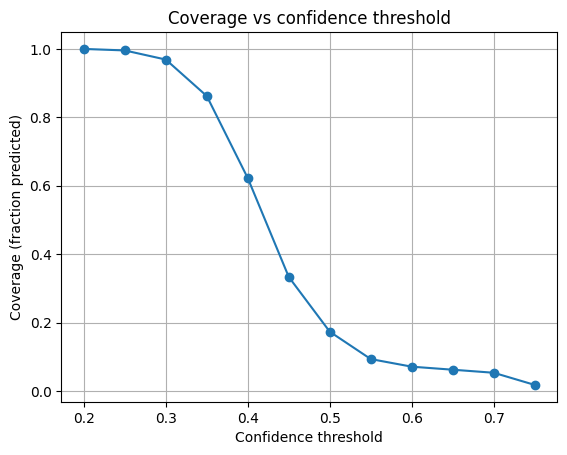

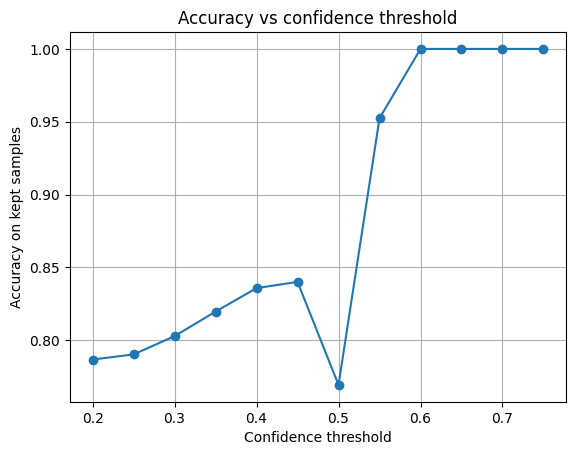

In [21]:
plt.figure()
plt.plot(curve["threshold"], curve["coverage"], marker="o")
plt.xlabel("Confidence threshold")
plt.ylabel("Coverage (fraction predicted)")
plt.title("Coverage vs confidence threshold")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(curve["threshold"], curve["accuracy"], marker="o")
plt.xlabel("Confidence threshold")
plt.ylabel("Accuracy on kept samples")
plt.title("Accuracy vs confidence threshold")
plt.grid(True)
plt.show()

### Token-length analysis

Analyzing how the length of input texts (in tokens) affects model accuracy and confidence. This requires tokenizing the texts using the same tokenizer as the model.

In [26]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from IPython.display import display

tok = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast=True)

by_len = None

try:
    # --- compute token lengths (batched) ---
    if "text" in df_pred.columns:
        texts = df_pred["text"].fillna("").astype(str).tolist()
        enc = tok(texts, truncation=False, add_special_tokens=True)
        df_pred["n_tokens"] = [len(ids) for ids in enc["input_ids"]]

    elif ("title" in df_pred.columns) and ("perex" in df_pred.columns):
        titles = df_pred["title"].fillna("").astype(str).tolist()
        perexs  = df_pred["perex"].fillna("").astype(str).tolist()
        enc = tok(titles, perexs, truncation=False, add_special_tokens=True)
        df_pred["n_tokens"] = [len(ids) for ids in enc["input_ids"]]

    else:
        raise ValueError("Need either 'text' OR ('title' and 'perex') columns in df_pred.")

    # --- bucket + compare ---
    df_pred["len_bucket"] = pd.cut(
        df_pred["n_tokens"],
        bins=[0, 64, 128, 256],
        right=True,
        include_lowest=True,
    )

    # sanity checks
    if "correct" not in df_pred.columns:
        raise ValueError("Missing 'correct' column in df_pred (True/False per row).")
    if "conf" not in df_pred.columns:
        raise ValueError("Missing 'conf' column in df_pred (float confidence per row).")

    by_len = (
        df_pred.groupby("len_bucket", observed=False)
        .agg(
            n=("correct", "size"),
            acc=("correct", "mean"),
            avg_conf=("conf", "mean"),
        )
        .reset_index()
    )

except Exception as e:
    print("Token-length analysis failed:", repr(e))

# show output (always)
if by_len is not None:
    display(by_len)
    print("\nCounts by bucket:", by_len["n"].tolist())
else:
    print("No result produced.")

,len_bucket,n,acc,avg_conf
0,"(-0.001, 64.0]",88,0.727273,0.428806
1,"(64.0, 128.0]",97,0.804124,0.442885
2,"(128.0, 256.0]",40,0.875000,0.438110



Counts by bucket: [88, 97, 40]


### Conclusion

With the final **XLM-RoBERTa-base** run (**concat title + perex**, `split_seed=42`, `seed=101`, `max_length=256`, `sqrt_inv` class weights + focal **γ=1.0**), the model reaches **test accuracy = 0.7867**, **macro-F1 = 0.6441**, and **weighted-F1 = 0.7758**. That’s a solid outcome for a **6-class, clearly imbalanced** problem: accuracy/weighted-F1 confirm strong overall correctness, while macro-F1 shows the model is doing reasonably well beyond just predicting the dominant class.

From the per-class report, performance is **uneven** (as expected). **Reaction** is the easiest and dominates the dataset (high precision/recall and **F1 ≈ 0.87**), while **Interview** is the bottleneck (**F1 ≈ 0.33**, **recall ≈ 0.27**). The confusion matrix supports the story: many mistakes come from *borderline editorial categories* (e.g., items that read like *Reaction* but are actually *Interview* or *Pre-Match*). In other words, the remaining errors are less about language understanding and more about **label ambiguity + low support for minority classes**.

Two practical takeaways from the experiments:
- **Title-only is not enough** (it collapses macro-F1), so the perex carries crucial signal.
- **Longer `max_length` didn’t improve results**, suggesting either (a) most examples already fit within 256 tokens, or (b) the extra context past 256 tokens isn’t consistently relevant (noise dominates).
